# Setup

In [1]:
# rl  post-processing nb
# add a new notebook that takes in all config filepaths
# do modeling as a boolean
# dataset from config
# after proc it  prints out all results, 
# and puts them to a dataframe
# modeling if relevant and rewards

In [2]:
# here: implement variance ranking and 
# implement variance ranking in supervised baselines as well -> new notebook for just this?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import glob
from scipy.stats.stats import pearsonr
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, balanced_accuracy_score, mean_squared_error, r2_score

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

np.random.seed(42)


In [4]:
# which datasets to read and write

do_indian_pines = True 
do_salient_objects = True
do_plastic_flakes = True
do_soil_moisture = True
do_foods = True


In [5]:
num_b_kept = 30

## Define functions

In [6]:
# reward functions

def calculate_correlations(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    corr_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            if i != j:
                corr_sum += np.abs(pearsonr(data[:, i], 
                                   data[:, j])[0])
            
    return corr_sum/(len(selected_bands)**2)


def calculate_mutual_infos(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    normalized_mutual_info_score_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            if i != j:
                normalized_mutual_info_score_sum += normalized_mutual_info_score(data[:, i],
                                                                             data[:, j])
            
    return normalized_mutual_info_score_sum/(len(selected_bands)**2)


In [7]:
## dataset loading

def load_datasets(Dataset):
    
    if Dataset == 'SM':
        hyper_path = '../data/soil_moisture/hyperspectral_imagery/*npy'
        hyper = np.load(glob.glob(hyper_path)[0])
        gt_path = '../data/soil_moisture/gt_labels/*npy'
        gt = np.load(glob.glob(gt_path)[0])
        return hyper, gt
    
    if Dataset == 'IN':
        hyper_path = '../data/indian_pines/hyperspectral_imagery/*npy'
        hyper = np.load(glob.glob(hyper_path)[0])
        gt_path = '../data/indian_pines/gt_labels/*npy'
        gt = np.load(glob.glob(gt_path)[0])
        return hyper, gt
    
    if Dataset == 'SO':
        hyper_path = '../data/salient_objects/hyperspectral_imagery/salient-object-data.npy'
        gt_path = '../data/salient_objects/gt_labels/*npy'
        hypers=[]
        gt_labels=[]
        for i in range(len(glob.glob(hyper_path))):
            hyper = np.load(glob.glob(hyper_path)[i])
            hypers.append(hyper)
            gt = np.load(glob.glob(gt_path)[i])
            gt_labels.append(gt)
        return hypers, gt_labels 

                          
    if Dataset == 'PF':
        hyper_path = '../data/plastic_flakes/hyperspectral_imagery_2/plastic-flake-data.npy'
        gt_path = '../data/plastic_flakes/gt_labels/*npy'
        hypers=[]
        gt_labels=[]
        for i in range(len(glob.glob(hyper_path))):
            hyper = np.load(glob.glob(hyper_path)[i])
            hypers.append(hyper)
            gt = np.load(glob.glob(gt_path)[i])
            gt_labels.append(gt)
        return hypers, gt_labels
    
    if Dataset == 'Foods':
        hyper_path = '../data/foods/hyperspectral_imagery/*npy'
        gt_path = '../data/foods/gt_labels/*npy'
        hypers=[]
        gt_labels=[]
        for i in range(len(glob.glob(hyper_path))):
            hyper = np.load(glob.glob(hyper_path)[i])
            hypers.append(hyper)
            gt = np.load(glob.glob(gt_path)[i])
            gt_labels.append(gt)
        return hypers, gt_labels

## Plastic flakes dataset

In [131]:
# stacks all images vertically

# load data

if do_plastic_flakes:
    
    hyper, gt = load_datasets(
        'PF')
    
    hyper, gt = np.array(hyper), np.array(gt)
    
    hyper_multiple = np.squeeze(hyper)

    print('\nDataset info...')
    print('The shape of the original imagery:', hyper_multiple.shape)
    print('The shape of the original labels:', gt.shape)



Dataset info...
The shape of the original imagery: (123340, 224)
The shape of the original labels: (1, 112128)


In [132]:
# rewards
    
if do_plastic_flakes:
    
    num_runs = 50
    
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=num_b_kept))
    print(f'\nCorrelation reward for random num_b_kept bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=num_b_kept))
    print(f'Normalized mutual information reward for random num_b_kept bands, x{num_runs} runs:', np.mean(mis))
    



Correlation reward for random num_b_kept bands, x50 runs: 0.9222759637559149
Normalized mutual information reward for random num_b_kept bands, x50 runs: 0.5983492597447598


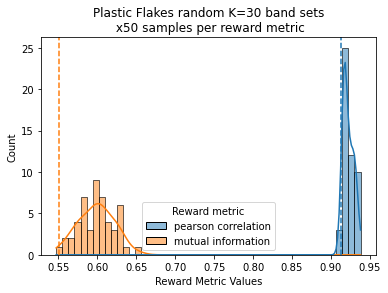

In [135]:
if do_plastic_flakes:
    
    # plot rewards
    #a_string = ['pearson correlation'] * len(correlations)    
    #b_string = ['mutual information'] * len(mis)
   # strings = a_string + b_string
   # pd_df = pd.DataFrame([correlations+mis, strings]).T
   # pd_df[0] = pd_df[0].astype(float, copy=True)
   #pd_df.columns = ['Reward Metric Values', 'Reward metric']
    pd_df = pd.read_csv('random_rewards_pf_cached.csv')
    sns.histplot(data=pd_df, bins=50, x='Reward Metric Values', hue='Reward metric', kde=True)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Plastic Flakes random K={num_b_kept} band sets\n x{num_runs} samples per reward metric')
    plt.axvline(x = 0.913136092, color = 'tab:blue', label = 'RL corr min after 750 iters', ls='--')
    plt.axvline(x = 0.550165266, color = 'tab:orange', label = 'RL mi min after 750 iters', ls='--')


In [134]:
pd_df.to_csv('random_rewards_pf_cached.csv')

## Salient objects dataset

In [8]:
# stacks all images vertically

# load data

if do_salient_objects:
    
    hyper, gt = load_datasets(
        'SO')
    
    hyper, gt = np.array(hyper), np.array(gt)
    
    hyper_multiple = np.squeeze(hyper)

    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper_multiple.shape)
    print('The shape of the original labels:', gt.shape)
 



Dataset info...
The shape of the original imagery: (471859, 81)
The shape of the original labels: (1, 786432)


In [102]:
# rewards
    
if do_salient_objects:
    
    num_runs = 50

    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=num_b_kept))
    print(f'\nCorrelation reward for random num_b_kept bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=num_b_kept))
    print(f'Normalized mutual information reward for random num_b_kept bands, x{num_runs} runs:', np.mean(mis))
    


Correlation reward for random num_b_kept bands, x50 runs: 0.08903726332699492
Normalized mutual information reward for random num_b_kept bands, x50 runs: 0.07999355085520758


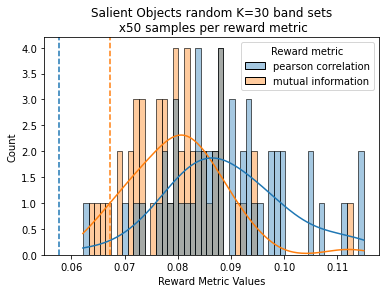

In [10]:
if do_salient_objects:
    
    # plot rewards
    #a_string = ['pearson correlation'] * len(correlations)    
    #b_string = ['mutual information'] * len(mis)
    #strings = a_string + b_string
    #pd_df = pd.DataFrame([correlations+mis, strings]).T
    #pd_df[0] = pd_df[0].astype(float, copy=True)
    #pd_df.columns = ['Reward Metric Values', 'Reward metric']
    pd_df = pd.read_csv('random_rewards_so_cached.csv')
    sns.histplot(data=pd_df, bins=50, x='Reward Metric Values', hue='Reward metric', kde=True, alpha=0.4)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Salient Objects random K={num_b_kept} band sets\n x{50} samples per reward metric')
    plt.axvline(x = 0.057759479, color = 'tab:blue', label = 'RL corr min after 750 iters', ls='--')
    plt.axvline(x = 0.067328676, color = 'tab:orange', label = 'RL mi min after 750 iters', ls='--')


In [106]:
#pd_df.to_csv('random_rewards_so_cached.csv')

## Indian Pines dataset

In [126]:
# load data

if do_indian_pines:
    
    hyper, gt = load_datasets(
        'IN')
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    


Dataset info...
The shape of the original imagery: (10249, 200)
The shape of the original labels: (10249,)


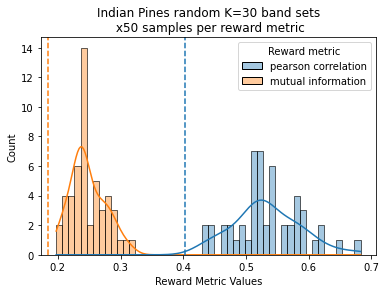

<Figure size 432x288 with 0 Axes>

In [130]:
# rewards
    
if do_indian_pines:
    """num_runs = 50
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'\nCorrelation reward for random num_b_kept bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'Normalized mutual information reward for random num_b_kept bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation'] * len(correlations)    
    b_string = ['mutual information'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    pd_df.columns = ['Reward Metric Values', 'Reward metric']"""
    pd_df = pd.read_csv('random_rewards_ip_cached.csv')
    sns.histplot(data=pd_df, bins=50, x='Reward Metric Values', hue='Reward metric', kde=True, alpha=0.4)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Indian Pines random K={num_b_kept} band sets\n x{num_runs} samples per reward metric')
    plt.axvline(x = 0.402303582, color = 'tab:blue', label = 'RL corr min after 750 iters', ls='--')
    plt.axvline(x = 0.184057316, color = 'tab:orange', label = 'RL mi min after 750 iters', ls='--')

    
    plt.show()
    plt.figure()

In [128]:
pd_df.to_csv('random_rewards_ip_cached.csv')

## Soil moisture dataset

In [121]:
# load data

if do_soil_moisture:
    
    hyper, gt = load_datasets(
        'SM')
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    


Dataset info...
The shape of the original imagery: (679, 125)
The shape of the original labels: (679,)



Correlation reward for random num_b_kept bands, x50 runs: 0.9457936367517766
Normalized mutual information reward for random num_b_kept bands, x50 runs: 0.6353218906608362


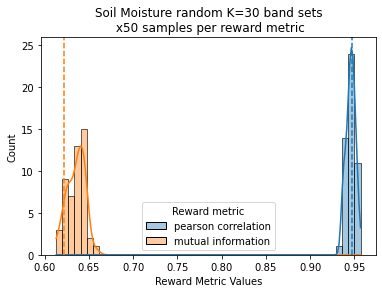

In [122]:
# rewards
    
if do_soil_moisture:
    num_runs = 50
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'\nCorrelation reward for random num_b_kept bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'Normalized mutual information reward for random num_b_kept bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation'] * len(correlations)    
    b_string = ['mutual information'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    pd_df.columns = ['Reward Metric Values', 'Reward metric']
    sns.histplot(data=pd_df, bins=50, x='Reward Metric Values', hue='Reward metric', kde=True, alpha=0.4)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Soil Moisture random K={num_b_kept} band sets\n x{num_runs} samples per reward metric')
    plt.axvline(x = 0.947005224, color = 'tab:blue', label = 'RL corr min after 750 iters', ls='--')
    plt.axvline(x = 0.620174848, color = 'tab:orange', label = 'RL mi min after 750 iters', ls='--')

    

## Foods dataset



Dataset info...
The shape of the original imagery: (2400, 96)
The shape of the original labels: (2400,)

Correlation reward for random num_b_kept bands, x50 runs: 0.5831041199148301
Normalized mutual information reward for random num_b_kept bands, x50 runs: 0.5874865616159082


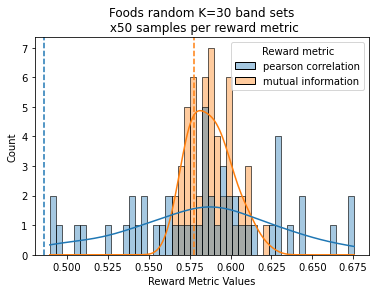

In [123]:
# load data

if do_foods:
    
    hyper, gt = load_datasets(
        'Foods')

    hyper, gt = hyper[0], gt[0]
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    
# rewards
    
if do_foods:
    num_runs = 50
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'\nCorrelation reward for random num_b_kept bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=num_b_kept))
    print(f'Normalized mutual information reward for random num_b_kept bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation'] * len(correlations)    
    b_string = ['mutual information'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    pd_df.columns = ['Reward Metric Values', 'Reward metric']
    sns.histplot(data=pd_df, bins=50, x='Reward Metric Values', hue='Reward metric', kde=True, alpha=0.4)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Foods random K={num_b_kept} band sets\n x{num_runs} samples per reward metric')
    plt.axvline(x = 0.485775135, color = 'tab:blue', label = 'RL corr min after 750 iters', ls='--')
    plt.axvline(x = 0.571780221, color = 'tab:orange', label = 'RL mi min after 750 iters', ls='--')
